https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [16]:
# Import necessary packages
import os
import seaborn as sns

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [21]:
import statsmodels.api as sm

In [68]:
energy_daily['load']

2012-01-01    71562.0
2012-01-02    76841.0
2012-01-03    87887.0
2012-01-04    92168.0
2012-01-05    88096.0
               ...   
2014-12-27    73845.0
2014-12-28    74678.0
2014-12-29    84486.0
2014-12-30    88810.0
2014-12-31    89246.0
Freq: D, Name: load, Length: 1096, dtype: float64

In [65]:
import numpy
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(energy_daily[['load']])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ValueError: too many values to unpack (expected 2)

Load data into Pandas dataframe

In [10]:
def load_data(data_dir):
    """Load the GEFCom 2014 energy load data"""

    energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy['timestamp']
    energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
    energy = energy.drop('timestamp', axis=1)

    return energy


def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()


def create_evaluation_df(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, H+1)])
    eval_df['timestamp'] = test_inputs.dataframe.index
    eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
    eval_df['actual'] = np.transpose(test_inputs['target']).ravel()
    eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
    return eval_df

In [11]:
energy = load_data('C:/Users/msala/Downloads/Sarima/data')[['load']]
energy.head()



,load
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


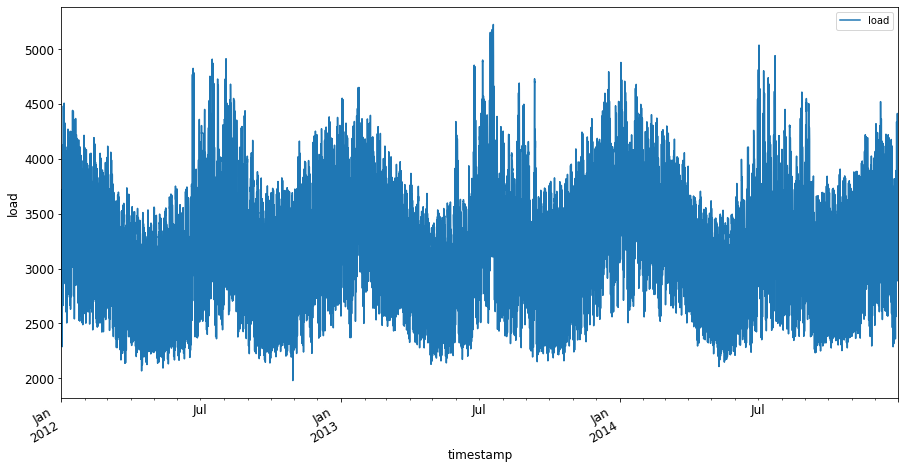

In [12]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Create training set containing only the model features

In [19]:
energy_daily = energy.resample('D').sum()
energy_daily.head()


,load
2012-01-01,71562.0
2012-01-02,76841.0
2012-01-03,87887.0
2012-01-04,92168.0
2012-01-05,88096.0


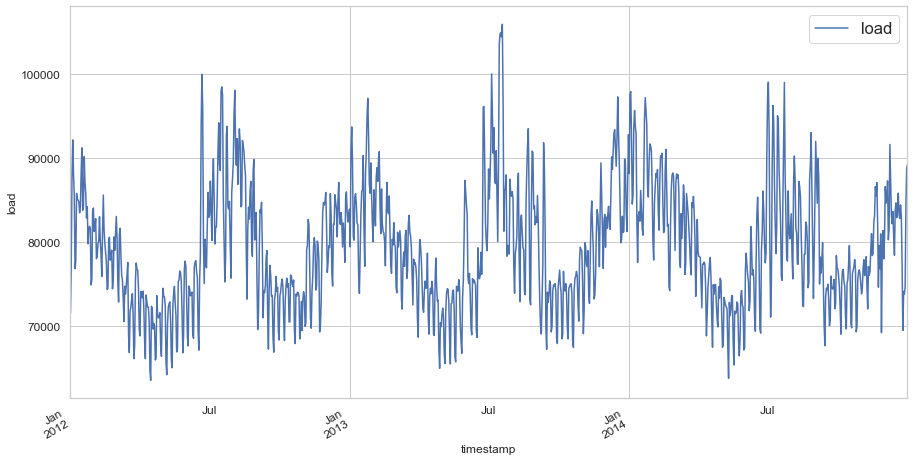

In [20]:
energy_daily.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

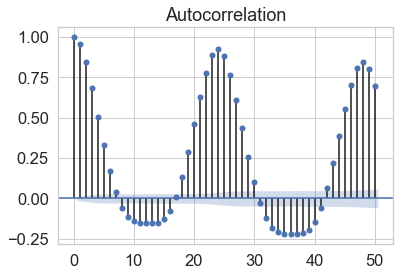

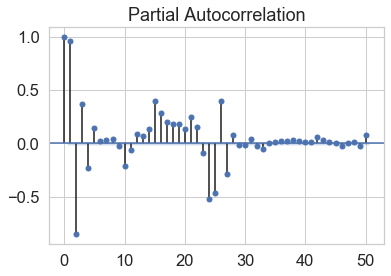

In [32]:
plot_acf(energy,lags=50)
plot_pacf(energy,lags=50)
plt.show()

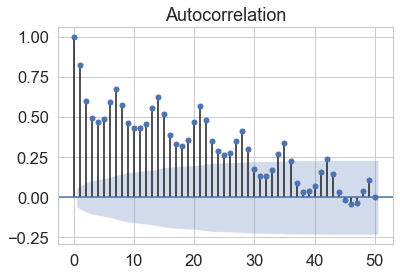

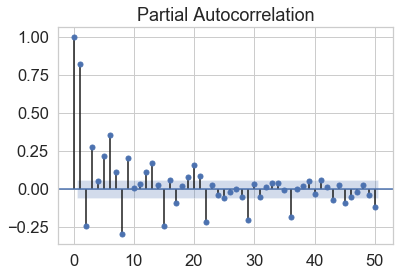

In [31]:
plot_acf(energy_daily,lags=50)
plot_pacf(energy_daily,lags=50)
plt.show()

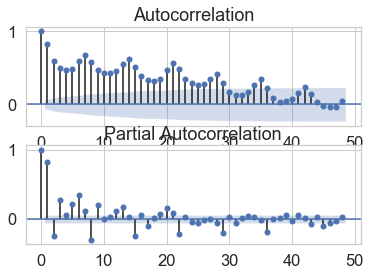

<Figure size 1440x432 with 0 Axes>

In [26]:
fig, ax = plt.subplots(2,1)
fig = plt.figure(figsize=(20, 6))
fig = sm.graphics.tsa.plot_acf(energy_daily, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(energy_daily, lags=50, ax=ax[1])
plt.show()

In [40]:
model = sm.tsa.statespace.SARIMAX(
    energy_daily, order=(0,1,1), seasonal_order=(0,1,1,7)).fit(max_iter=50, method='powell')


Optimization terminated successfully.
         Current function value: 9.439604
         Iterations: 2
         Function evaluations: 69


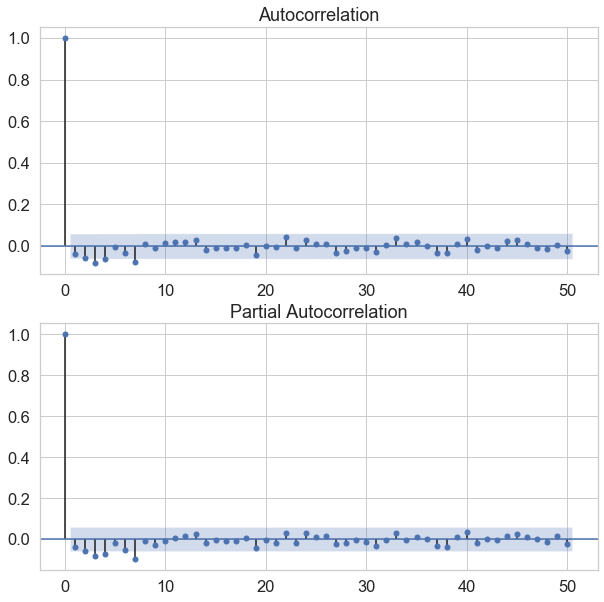

In [42]:

res = model.resid
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [50]:
import itertools
#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline


In [59]:
aicc=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(energy_daily,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            aicc.append('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue            

Optimization terminated successfully.
         Current function value: 9.439604
         Iterations: 2
         Function evaluations: 69
SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:20697.61275730274
Optimization terminated successfully.
         Current function value: 9.433175
         Iterations: 3
         Function evaluations: 141
SARIMA(0, 1, 1),(0, 1, 2, 7) - AIC:20685.52001652305
Optimization terminated successfully.
         Current function value: 9.433048
         Iterations: 3
         Function evaluations: 143
SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:20685.240955946152
Optimization terminated successfully.
         Current function value: 9.434083
         Iterations: 2
         Function evaluations: 115
SARIMA(0, 1, 1),(1, 1, 2, 7) - AIC:20689.509680096304
Optimization terminated successfully.
         Current function value: 9.436043
         Iterations: 4
         Function evaluations: 238
SARIMA(0, 1, 1),(2, 1, 1, 7) - AIC:20693.806321789743
Optimization terminated successfully.
     

In [60]:
aicc

['SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:20697.61275730274',
 'SARIMA(0, 1, 1),(0, 1, 2, 7) - AIC:20685.52001652305',
 'SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:20685.240955946152',
 'SARIMA(0, 1, 1),(1, 1, 2, 7) - AIC:20689.509680096304',
 'SARIMA(0, 1, 1),(2, 1, 1, 7) - AIC:20693.806321789743',
 'SARIMA(0, 1, 1),(2, 1, 2, 7) - AIC:20688.762262524142',
 'SARIMA(0, 1, 2),(0, 1, 1, 7) - AIC:20665.552124728372',
 'SARIMA(0, 1, 2),(0, 1, 2, 7) - AIC:20654.532686239298',
 'SARIMA(0, 1, 2),(1, 1, 1, 7) - AIC:20654.001452156634',
 'SARIMA(0, 1, 2),(1, 1, 2, 7) - AIC:20659.185232789525',
 'SARIMA(0, 1, 2),(2, 1, 1, 7) - AIC:20663.71945807046',
 'SARIMA(0, 1, 2),(2, 1, 2, 7) - AIC:20658.287713487436',
 'SARIMA(1, 1, 1),(0, 1, 1, 7) - AIC:20696.143489166046',
 'SARIMA(1, 1, 1),(0, 1, 2, 7) - AIC:20682.411168992603',
 'SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:20681.11108535362',
 'SARIMA(1, 1, 1),(1, 1, 2, 7) - AIC:20688.058680142625',
 'SARIMA(1, 1, 1),(2, 1, 1, 7) - AIC:20679.771838656205',
 'SARIMA(1, 1, 1),